## Transfer learning

2018 showed us that language modelling is a good task to train powerfull text representations. There are two different approaches how to use this representations: **feature extraction** and **fine-tuning**.

  * One great example of feature extraction is ELMo ([allennlp tutorial](https://github.com/allenai/allennlp/blob/master/tutorials/how_to/elmo.md), [tf_hub example](https://tfhub.dev/google/elmo/2), [deeppavlov documentation](http://docs.deeppavlov.ai/en/master/apiref/models/embedders.html?highlight=elmo#deeppavlov.models.embedders.elmo_embedder.ELMoEmbedder))
  * One great example of fine-tuning is ULMfit - ([fastai lesson](https://course.fast.ai/videos/?lesson=4), [example notebook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb))

What should you do?

  * Apply ELMo to make named entity recognition system. You can use [CONLL 2003 dataset (en)](http://files.deeppavlov.ai/deeppavlov_data/conll2003_v2.tar.gz) or [Persons1000 dataset (ru)](http://labinform.ru/pub/named_entities/descr_ne.htm) or any other dataset.
  * Apply ULMfit to make text classificator (any dataset, except IMDB)
  * Apply ELMo to make text classificator (on the same dataset)
  * Play with various models and hyperparameters
  * Compare results


**Results of this task:**
  * NER model
  * Two classification models
  * for each model:
    * metrics on the test set (quantitative evaluation)
    * succesfull and _unsucsessfull_ examples (qualitative evaluation)
    * plots showing that the model is training


**Additional points:**
  * Early stopping

In [2]:
!pip install allennlp # for getting elmo embeddings

    100% |████████████████████████████████| 5.6MB 6.3MB/s 
    100% |████████████████████████████████| 122kB 39.3MB/s 
    100% |████████████████████████████████| 51kB 24.7MB/s 
    100% |████████████████████████████████| 245kB 29.8MB/s 
    100% |████████████████████████████████| 133kB 34.0MB/s 
    100% |████████████████████████████████| 245kB 33.8MB/s 
    100% |████████████████████████████████| 552kB 27.5MB/s 
    100% |████████████████████████████████| 1.5MB 16.2MB/s 
    100% |████████████████████████████████| 51kB 23.5MB/s 
    100% |████████████████████████████████| 61kB 21.4MB/s 
    100% |████████████████████████████████| 2.3MB 15.3MB/s 
    100% |████████████████████████████████| 143kB 28.1MB/s 
    100% |████████████████████████████████| 51kB 27.1MB/s 
    100% |████████████████████████████████| 9.7MB 5.8MB/s 
    100% |████████████████████████████████| 92kB 35.5MB/s 
    100% |████████████████████████████████| 102kB 38.9MB/s 
    100% |████████████████████████████████| 204

In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torch.autograd as autograd
import torch.utils.data as utils
import random
import matplotlib.pyplot as plt
import time
import csv
import pandas as pd
import allennlp
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


# NER

*Online solver for cheaters*

In [6]:
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_path("https://s3-us-west-2.amazonaws.com/allennlp/models/ner-model-2018.12.18.tar.gz")
s = predictor.predict(
  sentence="Did Uriah honestly think he could beat The Legend of Zelda in under three hours?"
)
print(s)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


100%|██████████| 711306412/711306412 [00:10<00:00, 70296829.38B/s]
/usr/local/lib/python3.6/dist-packages/allennlp/data/token_indexers/token_characters_indexer.py:51: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  UserWarning)


{'logits': [[15.190458297729492, -4.716231822967529, 1.5143320560455322, -8.693986892700195, -5.3672637939453125, -1.8563754558563232, -3.214425802230835, -4.376181602478027, -6.056004524230957, -2.422358989715576, -4.920343399047852, -6.915403366088867, -2.8212313652038574, -4.298392295837402, -1.8804082870483398, -3.06772518157959, -4.711836338043213], [-1.3631693124771118, -2.0067806243896484, 4.746016025543213, 4.566849708557129, -0.578734815120697, 3.3536217212677, -3.244018316268921, -5.067802429199219, 16.73503875732422, -6.667780876159668, -3.404334783554077, -4.538154602050781, -3.13637113571167, -3.4001007080078125, -4.961193084716797, -6.998348236083984, -6.066359043121338], [12.128942489624023, -3.83430552482605, -6.2508344650268555, 1.3990728855133057, -6.805897235870361, -3.7989420890808105, -5.914254188537598, -1.5350010395050049, -3.1357712745666504, -1.1868269443511963, -7.6140336990356445, -0.8967913389205933, -3.826099157333374, -1.8193367719650269, -1.09013795852661

Read the train corpus (CONLL 2003 dataset (en))

In [7]:
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [8]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
print("Number of words: {}".format(len(words)))
tags = list(set(data["Tag"].values))
print("Number of tags: {}".format(len(tags)))
tag2idx = {t: i for i, t in enumerate(tags)}# indexes of tags

Number of words: 35179
Number of tags: 17


Class for getting sentece + tags

In [0]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(data)
sent = getter.get_next()
print(sent)
sentences = getter.sentences
print("Number of sentences: {}".format(len(sentences)))
print("Max len of sentence: {}".format(max([len(i) for i in sentences])))

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]
Number of sentences: 47959
Max len of sentence: 104


We need to choose max_len for inputting sentence to net

In [0]:
max_len = 50
X = [[w[0] for w in s][:max_len] for s in sentences]
new_X = []
for seq in X:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(seq[i])
        except:
            new_seq.append("__PAD__")
    new_X.append(new_seq)
X = new_X

Get idx for tags

In [0]:
y =[torch.tensor([ tag2idx[w[2]] for w in s][0:max_len]) for s in sentences]

In [0]:
y = (pad_sequence(sequences=y, batch_first=False, padding_value=tag2idx["O"])).t()

### Download elmo model from [allennlp](https://allennlp.org)

In [14]:
from allennlp.modules.elmo import Elmo, batch_to_ids

options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

# Compute two different representation for each token.
# Each representation is a linear weighted combination for the
# 3 layers in ELMo (i.e., charcnn, the outputs of the two BiLSTM))
elmo = Elmo(options_file, weight_file, 1, dropout=0)

100%|██████████| 374434792/374434792 [00:05<00:00, 69422539.32B/s]


In [0]:
def embed(batch):
  character_ids = batch_to_ids(batch)
  return elmo(character_ids)

In [16]:
embed([['First', 'sentence', '.'],['Russia', 'is', 'big','.','putin']])['elmo_representations'][0].shape

torch.Size([2, 5, 1024])

### Now we have word embedding of size 1024 for each word and tags(y)
Let's build a batcher +  model with bi-LSTM

In [0]:
class Batch:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.current = 0
    def make_batch(self, batch_size):
        if self.current + batch_size >= len(self.X):
            self.current = 0
        
        sample = embed(self.X[self.current:self.current+batch_size])['elmo_representations'][0].cuda()# batch * 50 * 1024
        pred = self.y[self.current:self.current+batch_size].cuda()
        self.current = self.current + batch_size
        return sample, pred

In [0]:
batch_size = 128
lr = 0.01
hidden_size = 1024
output_size = len(tag2idx)
n_layers = 2
n_batchs = 100
print_every = 1

In [0]:
class Net(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers, dropout = 0.2)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        out, hidden = self.lstm(x.view(1, batch_size, -1), hidden)
        out = self.decoder(out.view(batch_size, -1))
        return out, hidden
      
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device).cuda(),\
            torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device).cuda()
    
    def predict(x, hidden):
        batch_size = x.size(0)
        out, hidden = self.lstm(x.view(1, batch_size, -1), hidden)
        out = self.decoder(out.view(batch_size, -1))
        return out, hidden

In [0]:
model = Net(hidden_size, input_size, n_layers).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
loss = torch.tensor(0)
b = Batch(X, y)

In [0]:
def timeSince(since):
    now = time.clock()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
def train(inp, target):
    model.zero_grad()
    loss = 0
    hidden = model.init_hidden(batch_size)
    model.train()
    for i in range(inp.shape[1]-1):
        output, hidden = model(inp[:,i,:], hidden)
        loss += criterion(output.view(batch_size,-1), target[:,i])
        
    loss.backward()
    optimizer.step()
    
    return loss/ inp.shape[1]

In [0]:
losses = []

All corpus is $\approx$ 300 bathes, I use only 100 

In [258]:
start_time = time.clock()
for bat in range(1, n_batchs + 1):
    loss = train(*b.make_batch(batch_size))
    losses.append(loss)
    if bat % print_every == 0:
        print('bat {},   \tloss {}'.format(bat, losses[-1]))
        print('time passed %s:' %(timeSince(start_time)))
        

bat 1,   	loss 2.779780864715576
time passed 0m 34s:
bat 2,   	loss 1.01329505443573
time passed 1m 10s:
bat 3,   	loss 0.5626169443130493
time passed 1m 45s:
bat 4,   	loss 1.0504958629608154
time passed 2m 16s:
bat 5,   	loss 0.39138948917388916
time passed 2m 49s:
bat 6,   	loss 0.6237685084342957
time passed 3m 21s:
bat 7,   	loss 0.5682610273361206
time passed 3m 55s:
bat 8,   	loss 0.7098172307014465
time passed 4m 27s:
bat 9,   	loss 0.6765277981758118
time passed 4m 58s:
bat 10,   	loss 0.6005204916000366
time passed 5m 31s:
bat 11,   	loss 0.5897429585456848
time passed 6m 4s:
bat 12,   	loss 0.44916483759880066
time passed 6m 37s:
bat 13,   	loss 0.4250081181526184
time passed 7m 9s:
bat 14,   	loss 0.45406150817871094
time passed 7m 41s:
bat 15,   	loss 0.425199419260025
time passed 8m 14s:
bat 16,   	loss 0.3851526975631714
time passed 8m 47s:
bat 17,   	loss 0.4360050559043884
time passed 9m 21s:
bat 18,   	loss 0.4006953835487366
time passed 9m 52s:
bat 19,   	loss 0.3833

In [265]:
torch.save(model, 'gdrive/My Drive/Colab Notebooks/tr_learn_34.dms')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
torch.save(optimizer, 'gdrive/My Drive/Colab Notebooks/adam_tr_learn_34')

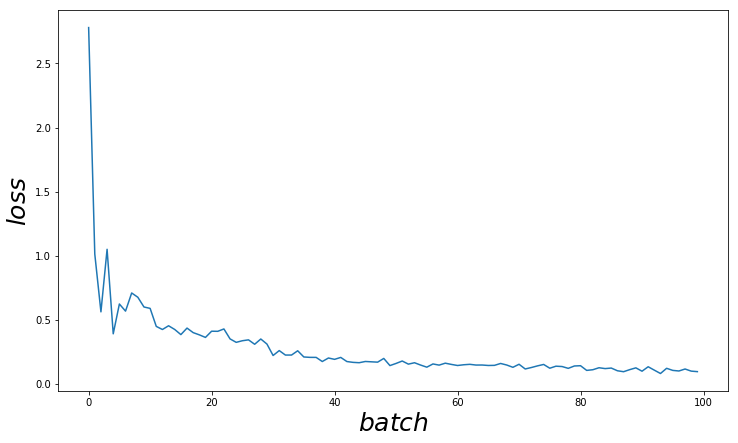

In [261]:
plt.figure(figsize=(12,7))
plt.plot(range(len(losses)), losses)
plt.xlabel("$batch$", fontsize=25)
plt.ylabel("$loss$", fontsize=25)
plt.show()

## Check accuracy + f1

In [0]:
def predict(batch_size):
    hidden = model.init_hidden(batch_size)
    inp, target = b.make_batch(batch_size)
    hidden = model.init_hidden(batch_size)
    pred = []
    for i in range(inp.shape[1]):
      output, hidden = model(j[:,i,:], hidden)
      _, index = torch.max(func.softmax(output, dim = 1),1)
      pred.append(index.item())
    return accuracy_score(target[0].cpu().detach().numpy(),pred), f1_score(target[0].cpu().detach().numpy(),pred, average='macro')
    

In [399]:
print('ACCURACY:\t {}'.format(np.mean([predict(1)[0] for i in range(10)])))
print('F1- SCORE:\t {}'.format(np.mean([predict(1)[1] for i in range(10)])))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ACCURACY:	 0.9339999999999999
F1- SCORE:	 0.2471519373509746


Accuracy is great, in case I taught model more, f1 would be around 0.8